# Voting analysis 

## Using dataset containing the history of votes from 1975 to 2019

The dataset is from data.world (https://data.world/datagraver/eurovision-song-contest-scores-1975-2019).

We have a theory that there are strong voting blocks in Europe, that neighboring countries give each other votes and that diaspora sometimes affects the votes, which can be more clearly seen in televoting points. 

First we will try to clean up the dataset, rename the columns to make the dataset easier to work with, clear up inconsistencies with names (North Macedonia also appears as F.Y.R. Macedonia and Macedonia, and there's a typo - The Netherlands appear as The Netherands).

Countries when voting, can give other countries 1, 2, 3, 4, 5, 6, 7, 8, 10 and 12 points. This scoring system has been the same since 1975. As of 2004, semi-finals were introduced to decide which countries would participate in the final. This year also introduced a significant change in voting, namely even countries which did not qualify for the final could still vote in the final. 

At first, scores were only decided by expert jurys. In 1997, televoting was introduced in some countries and the vote was decided by the combined amount of televoting and jury votes. Since 2001, all countries use televoting. Since 2016, the televoting and jury votes are presented separately, which means that each country votes twice. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go

from scipy.cluster import hierarchy as hc

%matplotlib inline
sns.set()

In [2]:

df = pd.read_excel("eurovision_song_contest_1975_2019v3.xlsx")

As we can see, the dataset has the columns:
<br>
Year (with values from 1975 to 2019)
<br>
(semi-)final
<br>
Edition - which combines the year and whether it's a final or a semi-final
<br>
From country - which country is voting
<br>
To country - which country are the points going to
<br>
Points - how many points
<br>
Duplicate - is it the same country in both the From and To columns

In [3]:
df.head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,1975,f,1975f,J,Belgium,France,2,NaN
3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,1975,f,1975f,J,Belgium,Ireland,12,NaN


Changing the columns names to make them easier to access:

In [4]:
df.set_axis(['year', 'round', 'edition', 'voters', 'from_country', 'to_country', 'points', 'duplicate'], 
            axis='columns', inplace=True)
df.tail()

,year,round,edition,voters,from_country,to_country,points,duplicate
49827,2019,f,2019f,J,Belarus,Greece,3,NaN
49828,2019,f,2019f,J,Belarus,Germany,0,NaN
49829,2019,f,2019f,J,Belarus,Belarus,0,x
49830,2019,f,2019f,J,Belarus,The Netherlands,6,NaN
49831,2019,f,2019f,J,Belarus,Russia,1,NaN


Eliminating all duplicate rows and deleting columns which are unnecessary:

In [5]:
df.query('duplicate != "x"', inplace=True)
df.drop(columns=['edition', 'duplicate']);

Let's see all the countries which are present in the dataset:

In [6]:
print(sorted(df['from_country'].unique()))

['Albania', 'Andorra', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia & Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'F.Y.R. Macedonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Macedonia', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Morocco', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Serbia & Montenegro', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'The Netherands', 'The Netherlands', 'Turkey', 'Ukraine', 'United Kingdom', 'Yugoslavia']


We need to edit out the name inconsistencies:

In [7]:
df.replace(to_replace=['The Netherands'], value='The Netherlands', inplace=True)
df.replace(to_replace=['Macedonia'], value='North Macedonia', inplace=True)
df.replace(to_replace=['F.Y.R. Macedonia'], value='North Macedonia', inplace=True)

In [8]:
countries_2019 = ['Albania', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Belarus', 
                  'Belgium', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 
                  'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 
                  'Ireland', 'Israel', 'Italy', 'Latvia', 'Lithuania', 'Malta', 'Moldova', 
                  'Montenegro', 'The Netherlands', 'North Macedonia', 'Norway', 'Poland', 
                  'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Slovenia', 
                  'Spain', 'Sweden', 'Switzerland', 'United Kingdom']


finalists_2019 = ['Albania', 'Australia', 'Azerbaijan', 'Belarus', 'Cyprus', 'Czech Republic', 
                  'Denmark', 'Estonia', 'France', 'Germany', 'Greece', 'Iceland', 'Israel', 
                  'Italy', 'Malta', 'The Netherlands', 'North Macedonia', 'Norway', 'Russia', 
                  'San Marino', 'Serbia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom']



In 2019, Ukraine, Bulgaria didn't participate even though Ukraine and Bulgaria have been regular participants up until 2019. Turkey participated until 2012 as well as Slovakia, Bosnia & Herzegovina was a regular participant until 2016. We'll include them in a list of all countries to analyse the data more accurately. 

Other outliers are Yugoslavia (which participated until 1992), 'Serbia and Montenegro' which participated as a combined country in 2004 and 2005, Luxembourg participated until 1993, Andorra's last time participating was in 2009, Morocco appeared once in 1980, Australia has been the latest addition (from 2015 to 2019) and Monaco stopped participating in 2006. 


In [9]:
all_countries = ['Albania', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Belarus', 
                  'Belgium', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 
                  'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 
                  'Ireland', 'Israel', 'Italy', 'Latvia', 'Lithuania', 'Malta', 'Moldova', 
                  'Montenegro', 'The Netherlands', 'North Macedonia', 'Norway', 'Poland', 
                  'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Slovenia', 
                  'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'Bulgaria', 'Ukraine', 
                  'Bosnia & Herzegovina', 'Turkey']

We can easily see all the points a specific country has been given by year, for example let's see Slovenia's success

In [10]:
df.query('to_country == "Slovenia"').groupby(['year', 'round', 'voters'])['points'].sum().to_frame()

,,,points
year,round,voters,
1993,f,J,9
1995,f,J,84
1996,f,J,16
1997,f,J,60
1998,f,J,17
1999,f,J,50
2001,f,J,70
2002,f,J,33
2003,f,J,7


Let's see which countries gave the most points to a specific country

In [11]:
df.query('to_country == "Slovenia"').groupby('from_country')['points'] \
        .aggregate([sum, 'count', max, np.mean]) \
        .sort_values(by=['mean', 'count'], ascending=False).head(n=20)

,sum,count,max,mean
from_country,,,,
Bosnia & Herzegovina,110,17,12,6.470588
Croatia,135,23,12,5.869565
Serbia,97,17,10,5.705882
Montenegro,90,17,12,5.294118
Serbia & Montenegro,14,3,7,4.666667
North Macedonia,73,19,10,3.842105
Czech Republic,42,12,12,3.500000
Poland,83,31,10,2.677419
Monaco,7,3,4,2.333333


Those were the combined votes. On the other hand, let's see how the televoting votes differ for Slovenia. We should mark that the separated televoting data is only available for years 2016 to 2019.

In [12]:
df.query('to_country == "Slovenia" and voters == "T"').groupby('from_country')['points'] \
        .aggregate([sum, 'count', max, np.mean]) \
        .sort_values(by=['mean', 'count'], ascending=False).head(n=15)

,sum,count,max,mean
from_country,,,,
Croatia,17,2,10,8.500000
Serbia,40,5,10,8.000000
Montenegro,36,5,10,7.200000
Estonia,14,3,7,4.666667
Hungary,15,4,7,3.750000
Poland,21,6,8,3.500000
Belarus,13,4,8,3.250000
Portugal,11,4,7,2.750000
Russia,8,3,6,2.666667


Which countries are Slovenia's favourite, i.e. which countries has it given the most points to?

In [13]:
df.query('from_country == "Slovenia"').groupby('to_country')['points'] \
        .aggregate([sum, 'count', max, np.mean]) \
        .sort_values(by=['mean', 'count'], ascending=False).head(n=15)

,sum,count,max,mean
to_country,,,,
Serbia & Montenegro,34,3,12,11.333333
Serbia,185,22,12,8.409091
Croatia,184,25,12,7.360000
Bosnia & Herzegovina,151,22,12,6.863636
North Macedonia,120,18,12,6.666667
Montenegro,63,12,10,5.250000
Italy,73,15,10,4.866667
Sweden,180,37,12,4.864865
Czech Republic,53,12,12,4.416667


What if we only take the televoting votes into account?

In [14]:
df.query('from_country == "Slovenia" and voters == "T"').groupby('to_country')['points'] \
        .aggregate([sum, 'count', max, np.mean]) \
        .sort_values(by=['mean', 'count'], ascending=False).head(n=15)

,sum,count,max,mean
to_country,,,,
Serbia,70,6,12,11.666667
North Macedonia,22,2,12,11.000000
Croatia,20,2,12,10.000000
Italy,29,4,10,7.250000
Montenegro,20,3,7,6.666667
Iceland,17,3,10,5.666667
Portugal,20,4,12,5.000000
Moldova,19,4,10,4.750000
Norway,23,5,10,4.600000


We could argue that here we see the diaspora effect. Slovenia has a lot of immigrants from Serbia, North Macedonia, Croatia and Italy (unfortunately Bosnia stopped participating before we could see the divided televoting data, even though according to stat.si the largest percentage of immigration to Slovenia is from Bosnia & Herzegovina)

## Analysis of the votes of all participating countries in 2019

In [15]:
def voting_query(expr, target, index_countries, own='NaN'):
    
    matrix_df = pd.DataFrame(index=index_countries, columns=target)

    for to_country in target:

        # Add a column for each finalist:
        matrix_df[to_country] = df.query(expr).groupby('from_country')['points'] \
            .aggregate([np.mean])['mean'] \
            .filter(items=index_countries)

        # Assign a punctuation to itself:
        if to_country in target:
            matrix_df.loc[to_country, to_country] = float(own)
    
    return matrix_df

def plot_matrix(matrix_df, summary):   
    plt.figure(figsize=(22,14))
    ax = sns.heatmap(matrix_df.round(1), annot=True, fmt='g', cmap='Blues', linecolor='white', linewidths=1)
    ax.tick_params(axis='x', labelbottom=True, labeltop=True, labelrotation=90, labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_title('\n' + summary, fontsize=17);
    ax.set_xlabel("\nFinalists\n", fontsize=13);
    ax.set_ylabel("\nCountries with the right to vote\n", fontsize=14);

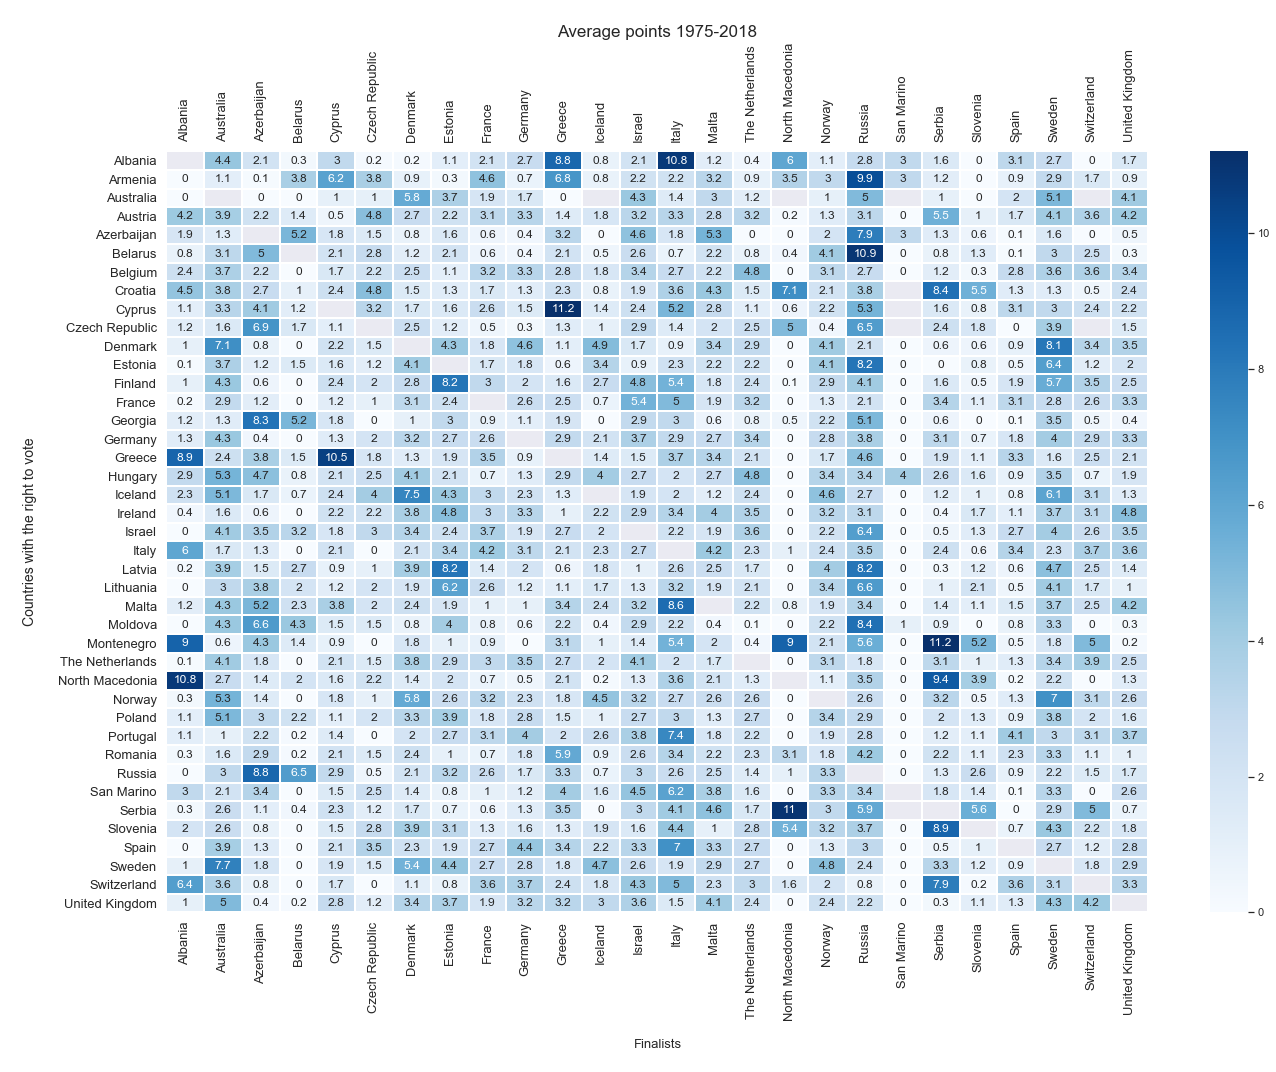

In [16]:
voting_matrix_2019 = voting_query('to_country == @to_country and round == "f" and year!=2019', finalists_2019, countries_2019)
plot_matrix(voting_matrix_2019, 'Average points 1975-2018')

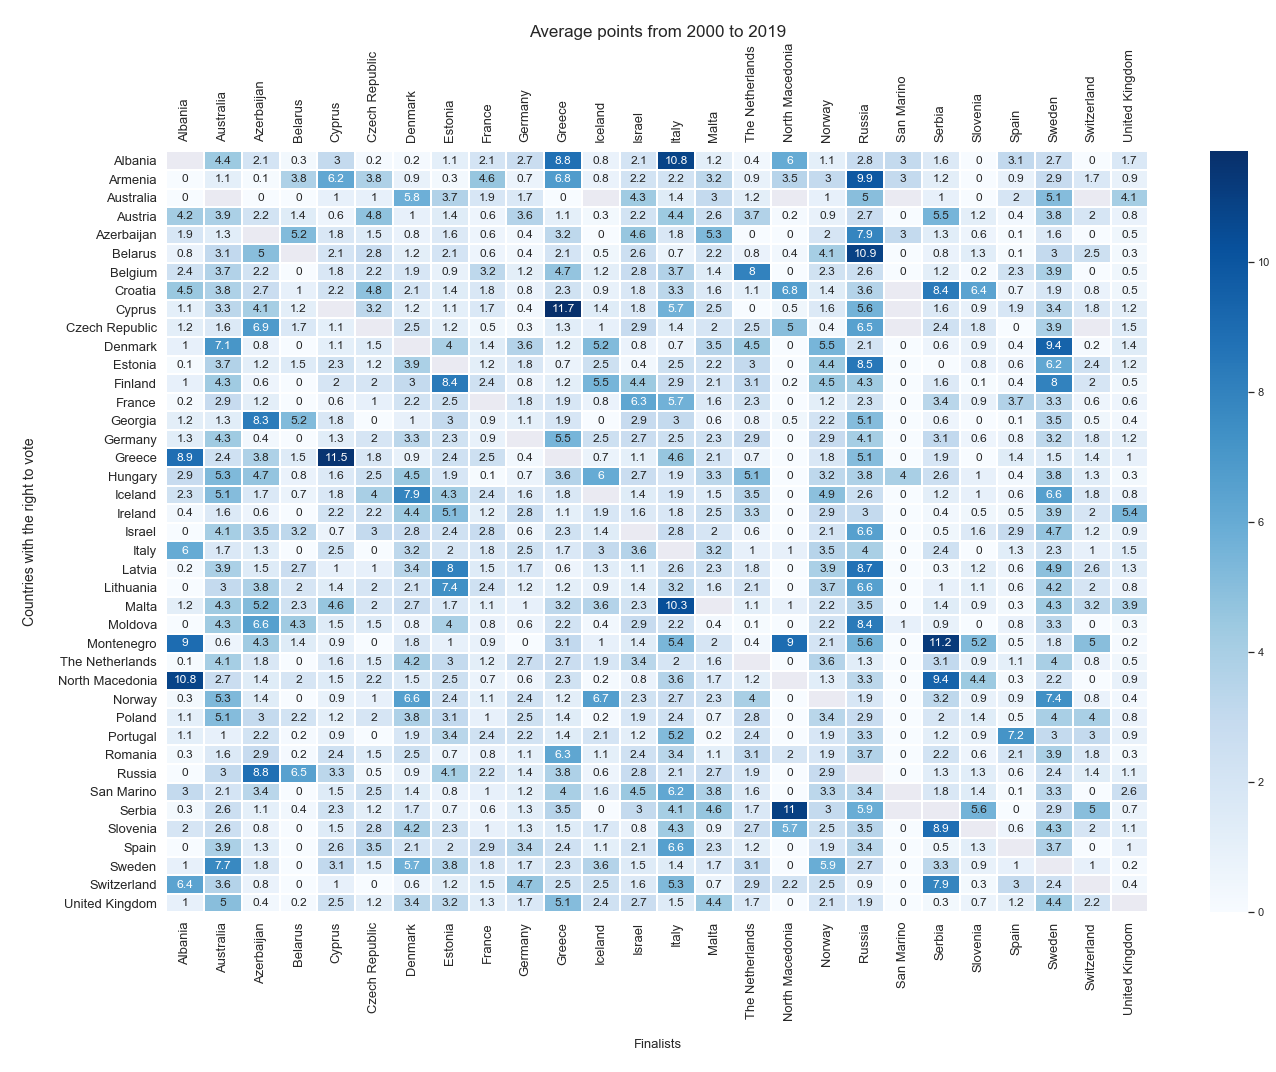

In [17]:
voting_matrix = voting_query('to_country == @to_country and round == "f" and year>2000 and year<2019', finalists_2019, countries_2019)
plot_matrix(voting_matrix, 'Average points from 2000 to 2019')

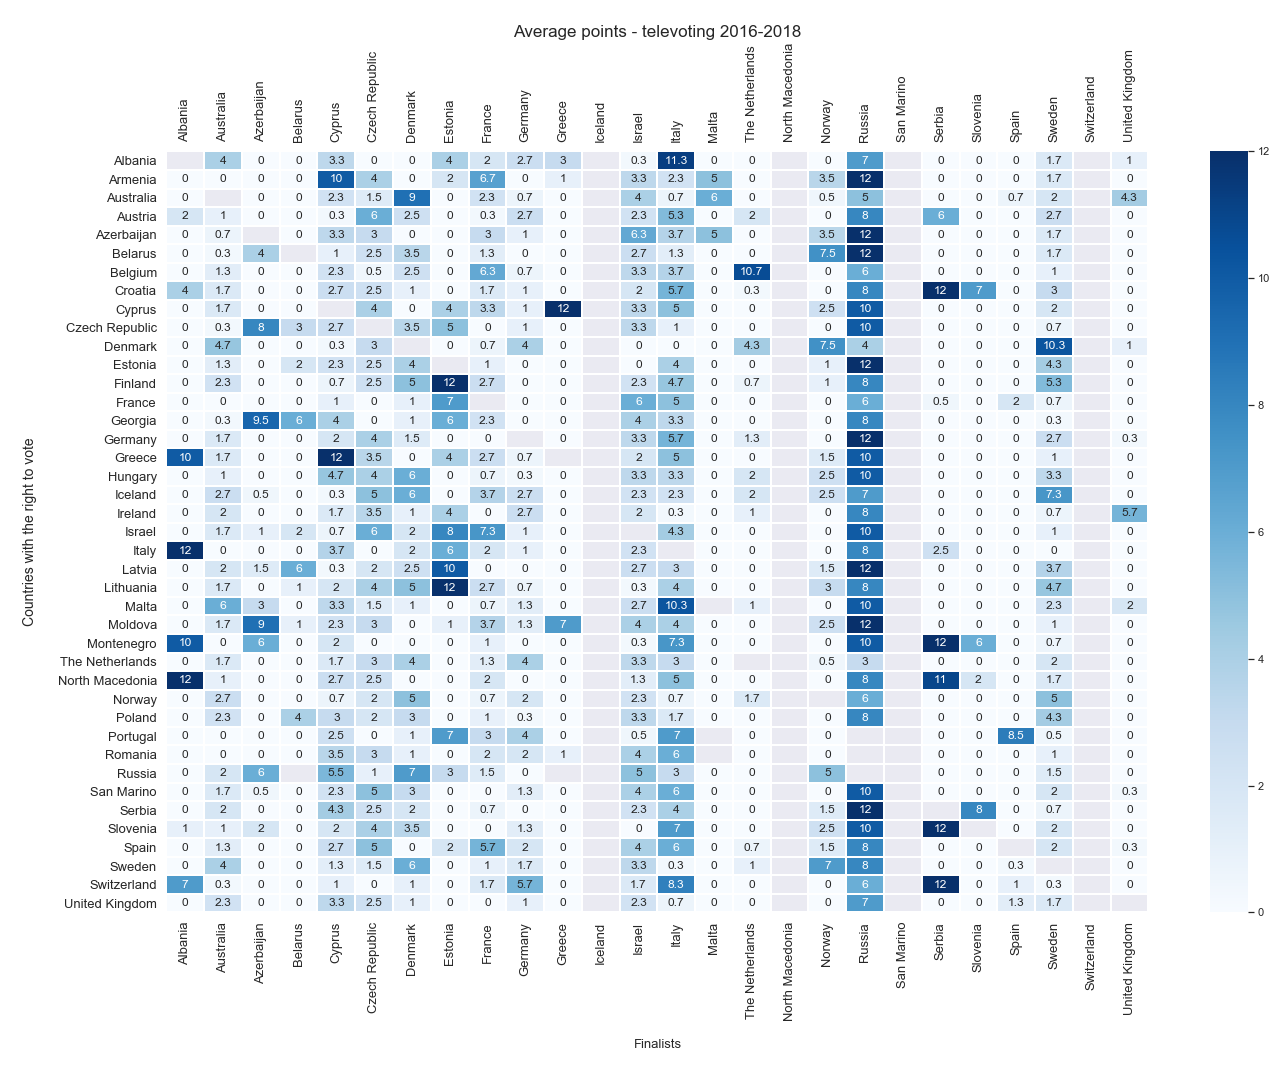

In [18]:
voting_matrix_t = voting_query('to_country == @to_country and year > 2015 and year <2019 and round == "f" and voters == "T"', finalists_2019, countries_2019)
plot_matrix(voting_matrix_t, 'Average points - televoting 2016-2018')

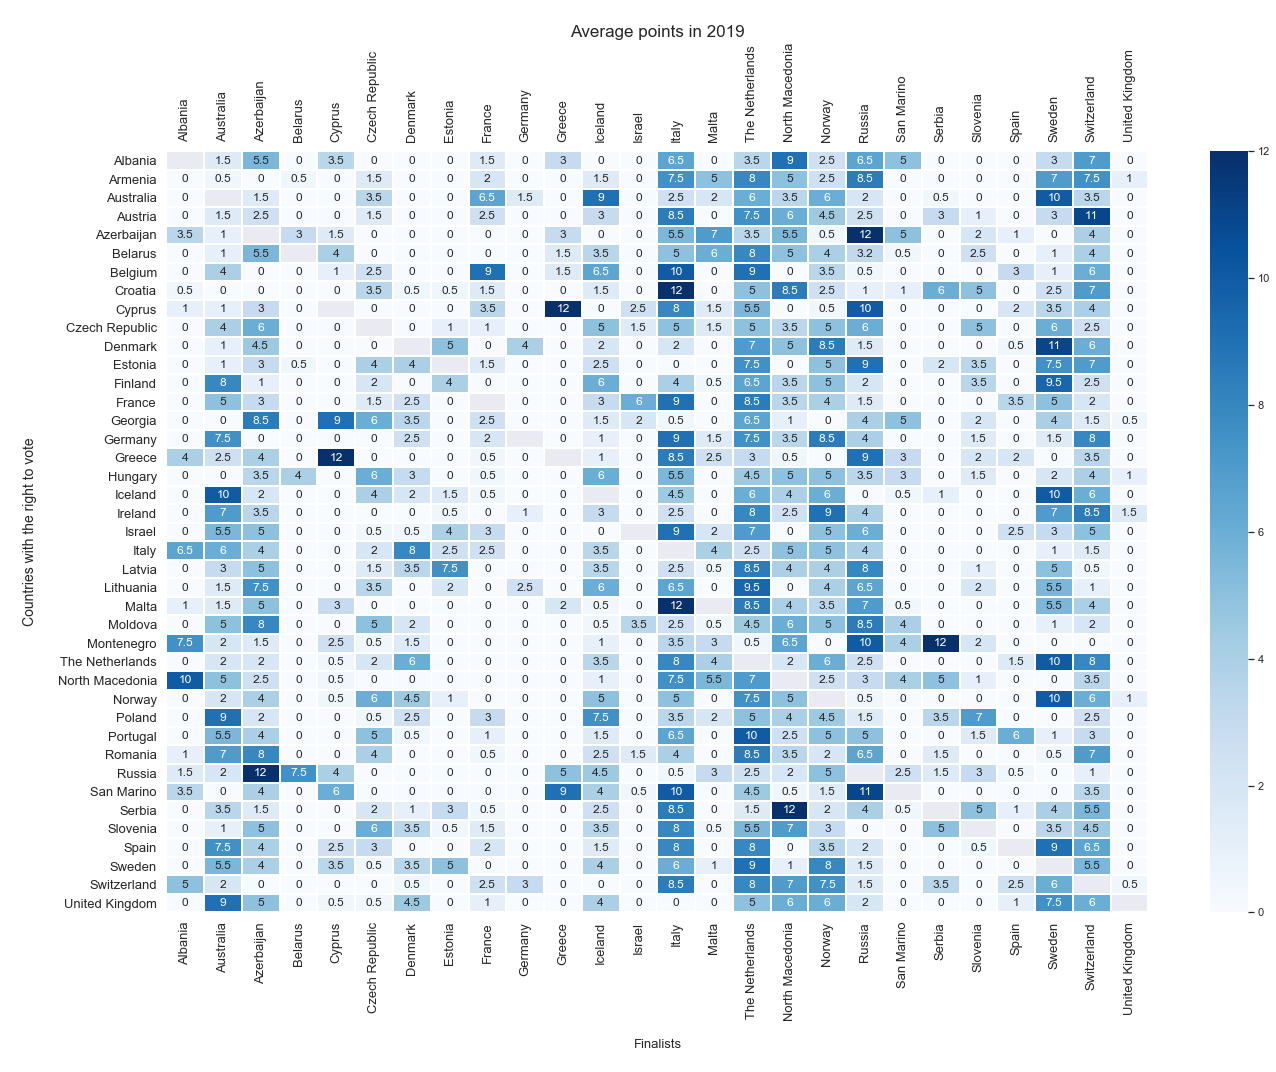

In [19]:
voting_matrix = voting_query('to_country == @to_country and round == "f" and year==2019', finalists_2019, countries_2019)
plot_matrix(voting_matrix, 'Average points in 2019')

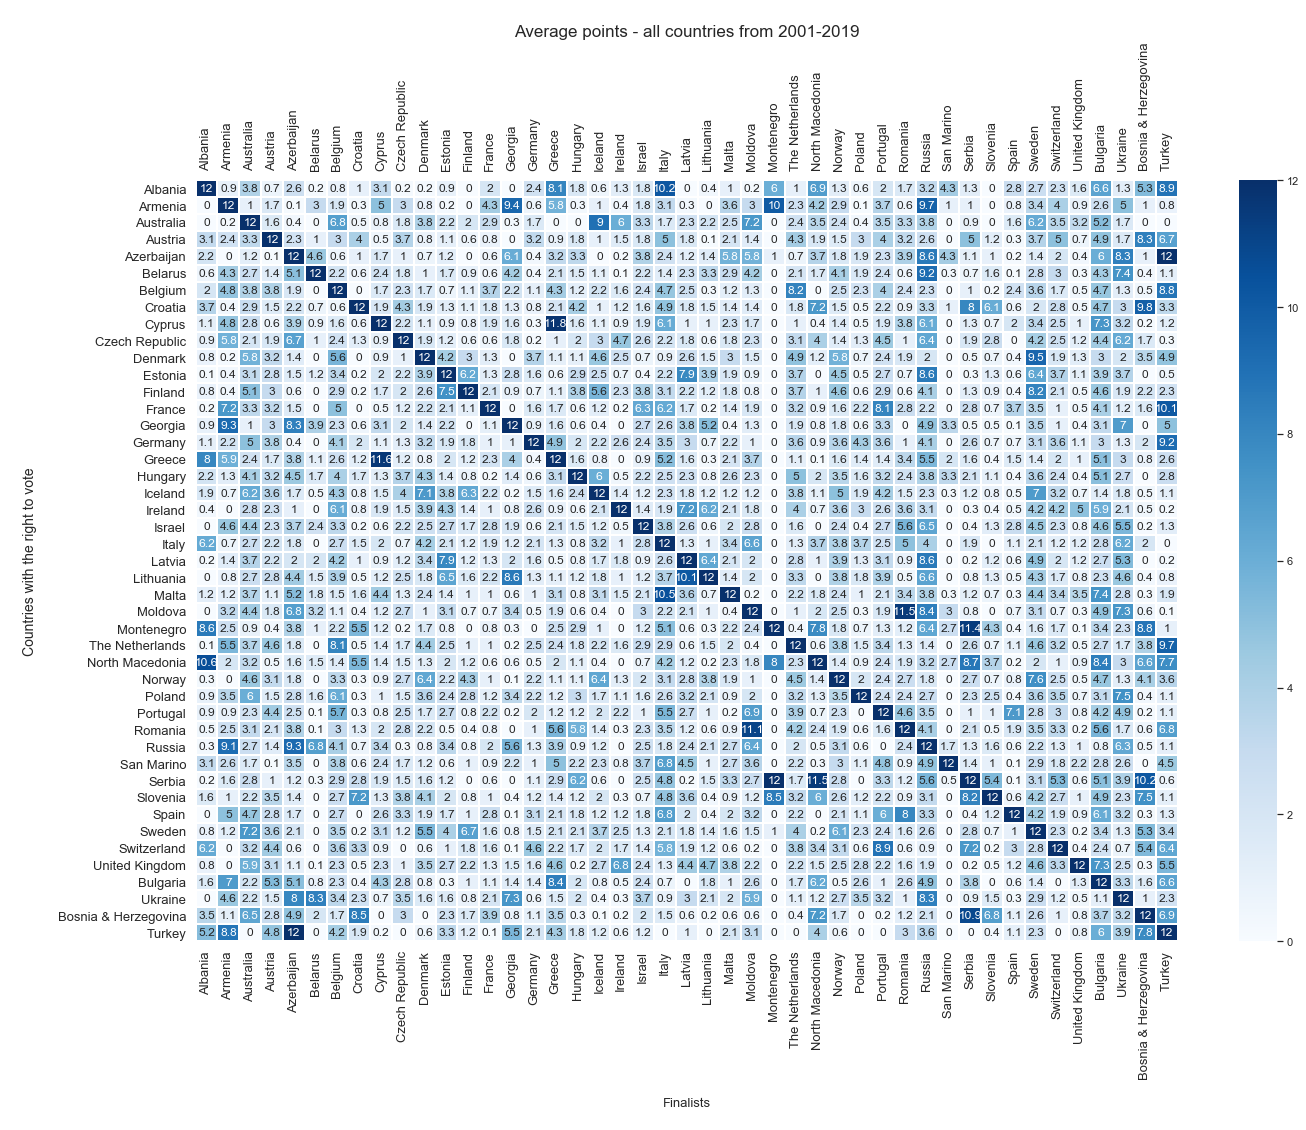

In [20]:
voting_matrix_all = voting_query('to_country == @to_country and round == "f" and year>2000', 
                                      all_countries, all_countries, own=12)

voting_matrix_all.fillna(0, inplace=True)

plot_matrix(voting_matrix_all, 'Average points - all countries from 2001-2019')

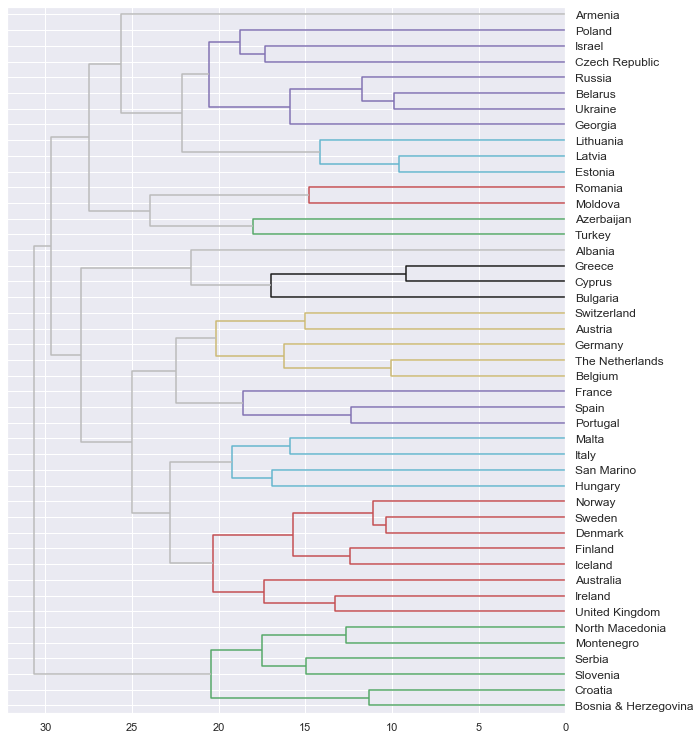

In [21]:
linkages = hc.linkage(voting_matrix_all, method='complete', optimal_ordering=True)

fig = plt.figure(figsize=(10,13))
hc.dendrogram(linkages, labels=all_countries, orientation='left',
              above_threshold_color='#bbbbbb', leaf_font_size=12)
plt.show();

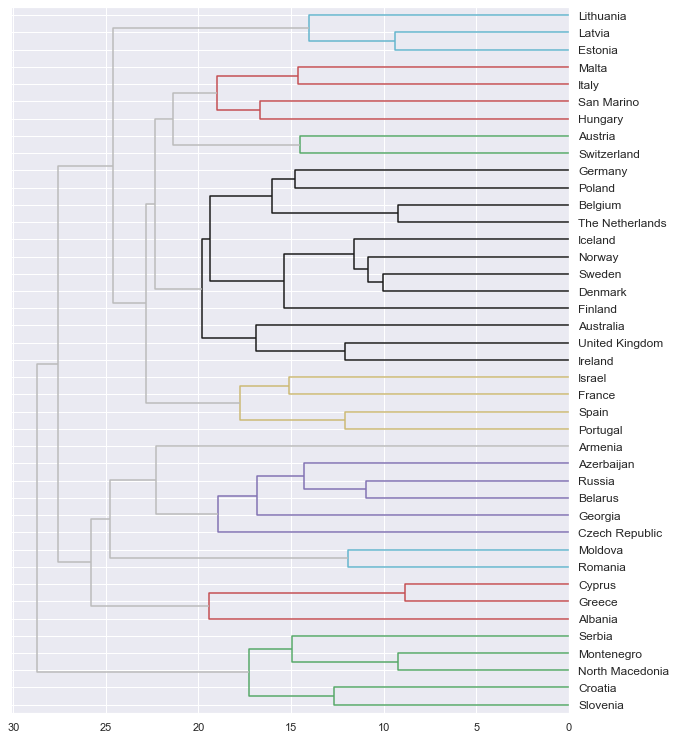

In [22]:
voting_matrix_all_2019 = voting_query('to_country == @to_country and round == "f" and year>2000', 
                                     countries_2019, countries_2019, own=12)

voting_matrix_all_2019.fillna(voting_matrix_all.mean(), inplace=True)

linkages = hc.linkage(voting_matrix_all_2019, method='complete', optimal_ordering=True)

fig = plt.figure(figsize=(10,13))
hc.dendrogram(linkages, labels=countries_2019, orientation='left',
              above_threshold_color='#bbbbbb', leaf_font_size=12)
plt.show();

## What happens if you don't have neighbors to vote for you?
Let's see the data for Australia and Malta, two countries that don't technically have neighbors.

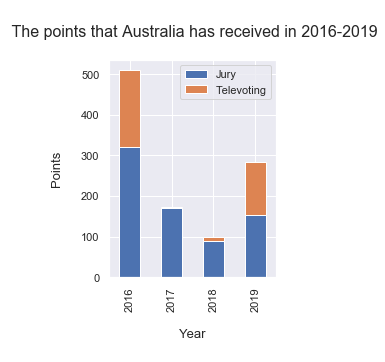

In [23]:
result = df.query('to_country == "Australia" and round == "f" and year > 2015') \
    .groupby(['year', 'voters'])['points'].sum().to_frame()


ax = result.reset_index().pivot_table(index="voters", columns="year", values="points") \
    .T.plot(kind='bar', stacked=True, figsize=(3, 4));

ax.set_title('\n The points that Australia has received in 2016-2019\n', fontsize=16)
ax.set_xlabel("\nYear\n", fontsize=13);
ax.set_ylabel("\nPoints\n", fontsize=13);
ax.legend(labels=['Jury', 'Televoting']);

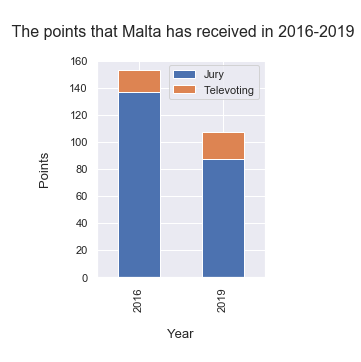

In [24]:
result = df.query('to_country == "Malta" and round == "f" and year > 2015') \
    .groupby(['year', 'voters'])['points'].sum().to_frame()


ax = result.reset_index().pivot_table(index="voters", columns="year", values="points") \
    .T.plot(kind='bar', stacked=True, figsize=(3, 4));

ax.set_title('\n The points that Malta has received in 2016-2019\n', fontsize=16)
ax.set_xlabel("\nYear\n", fontsize=13);
ax.set_ylabel("\nPoints\n", fontsize=13);
ax.legend(labels=['Jury', 'Televoting']);

## What are the top 3 friends of each country?

In [25]:

def get_top3_friends():
    num = 3
    order = np.argsort(-voting_matrix_all.values, axis=1)[:, :num]
    countries_friends = pd.DataFrame(voting_matrix_all.columns[order], 
                          columns=['top {}'.format(i) for i in range(1, num+1)],
                          index=voting_matrix_all.index)
    return countries_friends
voting_matrix_all = voting_query('to_country == @to_country and round == "f"', 
                                     all_countries, all_countries, own=0)
countries_friends = get_top3_friends()

C:\Users\Ana\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


In [26]:
import six
def render_mpl_table(data, col_width=3.0, row_height=0.425, font_size=13,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, 
                         rowLabels=data.index, rowLoc='right', **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        elif k[1] < header_columns:
            cell.set_text_props(weight='bold')
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
            cell.set_text_props(ha='center')
    return ax

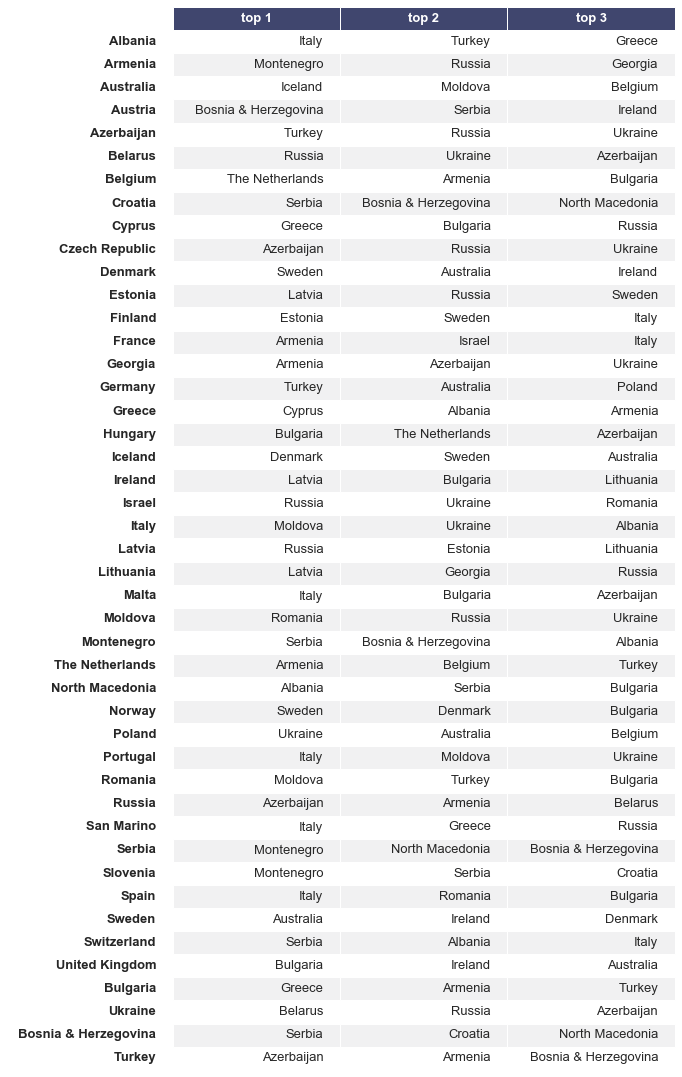

In [27]:
render_mpl_table(countries_friends, header_columns=0, col_width=3);

## Jury versus Televoting

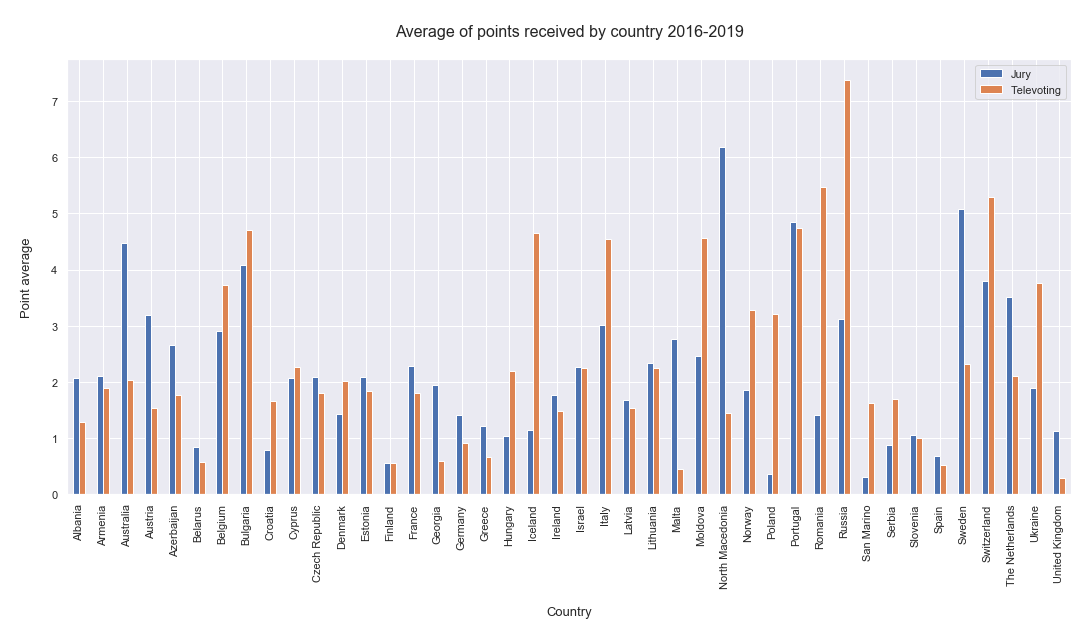

In [28]:
result = df.query('year > 2015 and round == "f"').groupby(['to_country', 'voters'])['points'] \
        .aggregate([np.mean]) \
        .sort_values(by=['to_country', 'voters', 'mean'], ascending=True)

ax = result.reset_index().pivot_table(index="voters", columns="to_country", values="mean") \
    .T.plot(kind='bar', stacked=False, figsize=(18, 8));

ax.set_title('\nAverage of points received by country 2016-2019\n', fontsize=16)
ax.set_xlabel("\nCountry\n", fontsize=13);
ax.set_ylabel("\nPoint average\n", fontsize=13);
ax.legend(labels=['Jury', 'Televoting']);



## Examining the diaspora effect

We'll analyse the 2016-2019 jury vs televoting data for Slovenia, France, Spain, Russia, Italy, United Kingdom and Germany as countries with a large immigrant population, in order to see whether the televoting differs precisely because of the diaspora voting for their "home" countries.

In [29]:
def jvt(country):
    
    result = df.query('from_country == "%s" and year > 2015 and round == "f"' % country) \
        .groupby(['to_country', 'voters'])['points'] \
        .aggregate([np.mean]) \
        .sort_values(by=['to_country'], ascending=True)

    ax = result.reset_index().pivot_table(index="voters", columns="to_country", values="mean") \
        .T.plot(kind='bar', stacked=True, figsize=(18, 8));

    ax.set_title('\nAverage of points given from %s since 2016\n' % country, fontsize=16)
    ax.set_xlabel("\nCountry\n", fontsize=13);
    ax.set_ylabel("\nPoint average\n", fontsize=13);
    ax.legend(labels=['Jury', 'Televoting']);

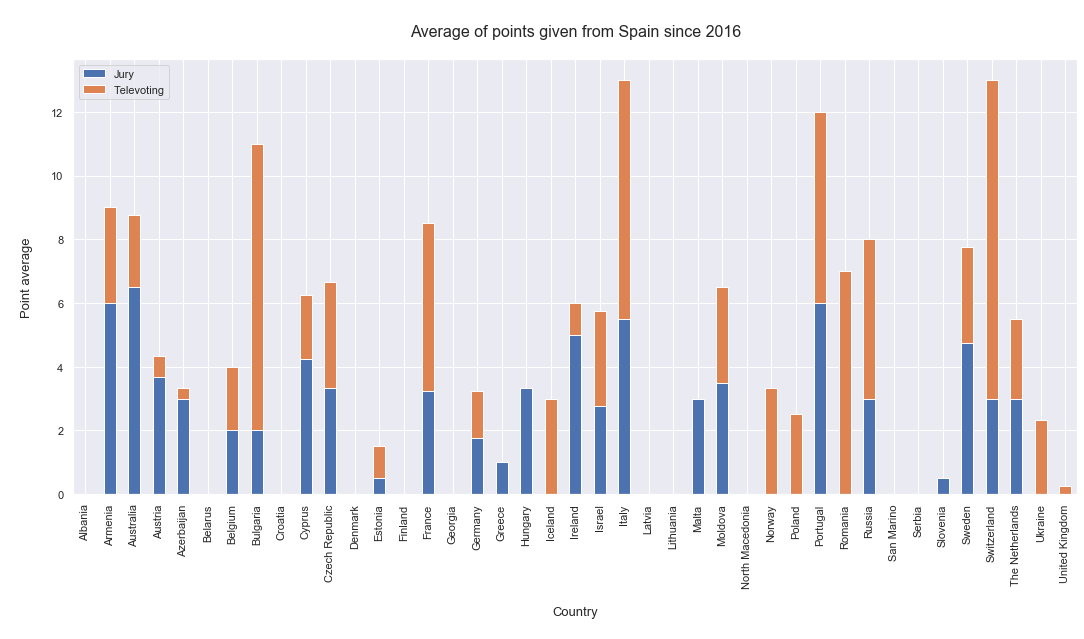

In [30]:
jvt("Spain")

We have to look at the imbalance of the vote:
<br>
For example, the countries which received a lot more votes from the public than from the jury are: Bulgaria, Czech Republic, Romania, Ukraine, Poland, Estonia and Russia. Countries that received more votes from the jury are: Australia, Austria, Greece, Hungary, Ireland and Malta.
<br>
According to the INE (official records for the immigration data for Spain from 2017) the countries with the most emigrants to Spain are: Romania, Bulgaria, United Kingdom, Italy, Germany, France, Portugal and Poland. 
<br>
So we can see that there's an overlap between the two. 

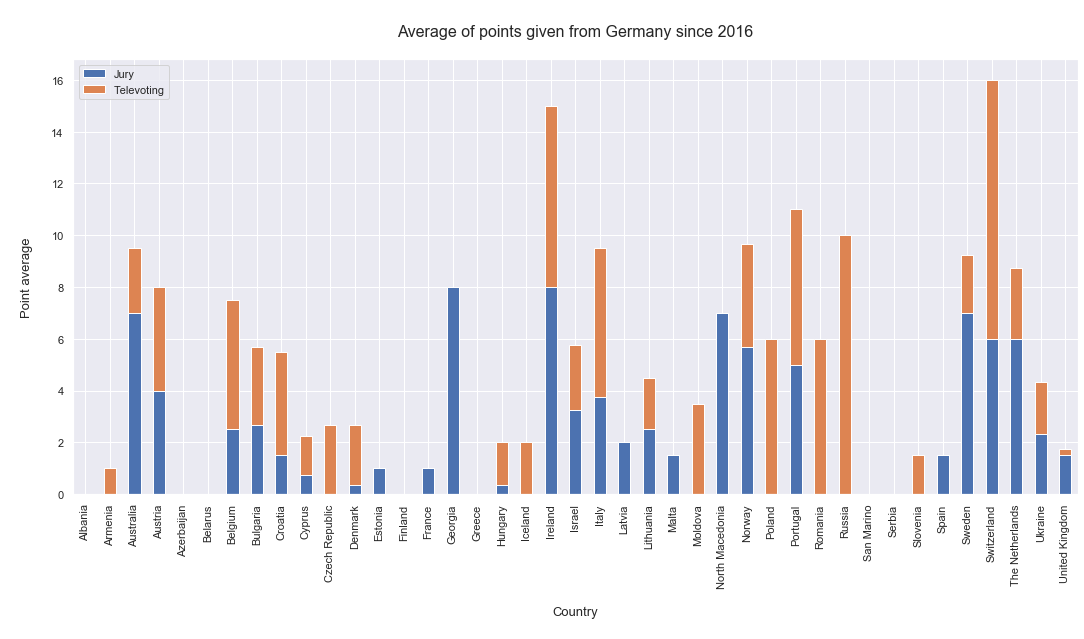

In [31]:
jvt("Germany")

In Germany, the countries which got a lot more votes from the public are:
<br>
Romania, Russia, Poland, Croatia, Belgium, Czech Republic, Slovenia, Denmark, Hungary, Iceland, Switzerland and Italy.
<br>
As of 2019, the most common groups of resident foreign nationals (from European countries) in Germany were:
Poland, Romania, Italy, Croatia, Greece, Bulgaria, Russia, Serbia, Hungary etc.
<br>
Once again, there's an overlap.

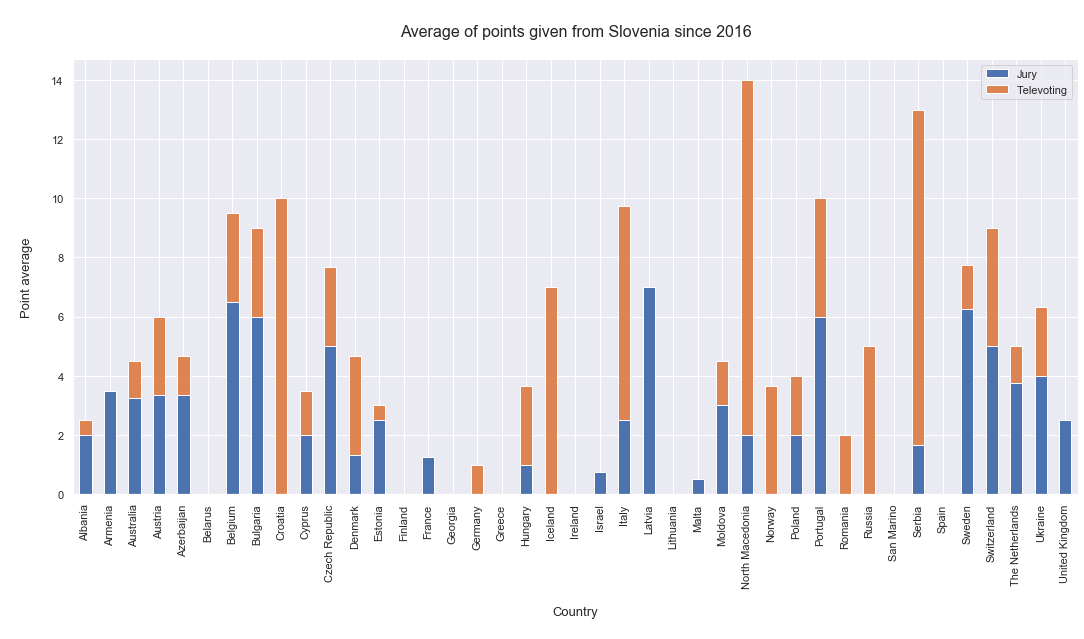

In [32]:
jvt("Slovenia")

Countries which got significantly more points from the public:
<br>
Croatia, Denmark, Hungary, Italy, North Macedonia, Romania, Russia and Serbia.
<br>
Countries with a large emigrant population to Slovenia:
<br>
Croatia, Hungary, Italy, Serbia, North Macedonia, Bosnia & Herzegovina. 

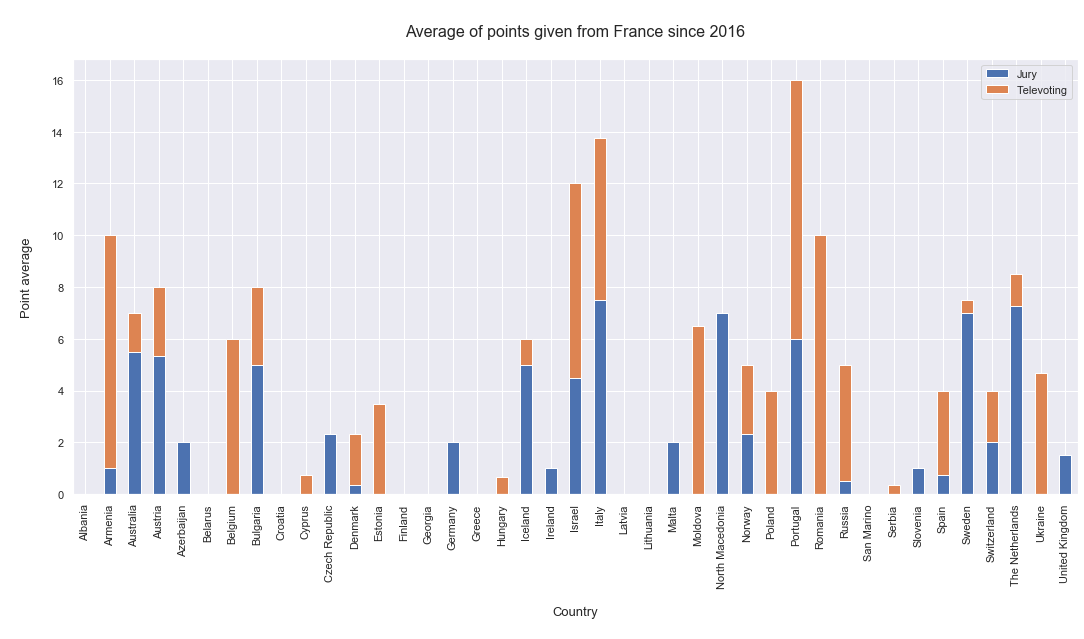

In [33]:
jvt("France")

Countries which got significantly more points from the public:
<br>
Armenia, Belgium, Estonia, Israel, Moldova, Portugal, Poland, Romania, Russia, Spain and Ukraine.
<br>
Countries with a large emigrant population to France:
<br>
Portugal, United Kingdom, Spain, Italy, Germany, Romania, Belgium, Russia, Switzerland, Poland.

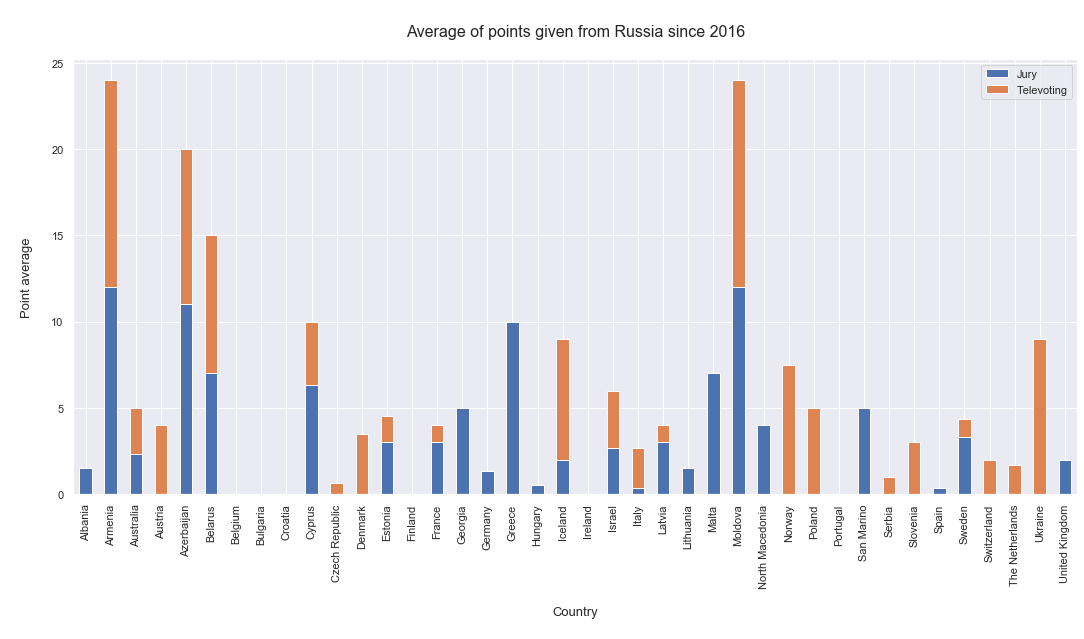

In [34]:
jvt("Russia")

Countries which got significantly more points from the public:
<br>
Austria, Armenia, Belarus, Denmark, Iceland, Moldova, Norway, Poland, Slovenia, Ukraine.
<br>
Countries with a large emigrant population to Russia:
<br>
Ukraine, Armenia, Moldova, Belarus, Germany, Georgia, Latvia.  

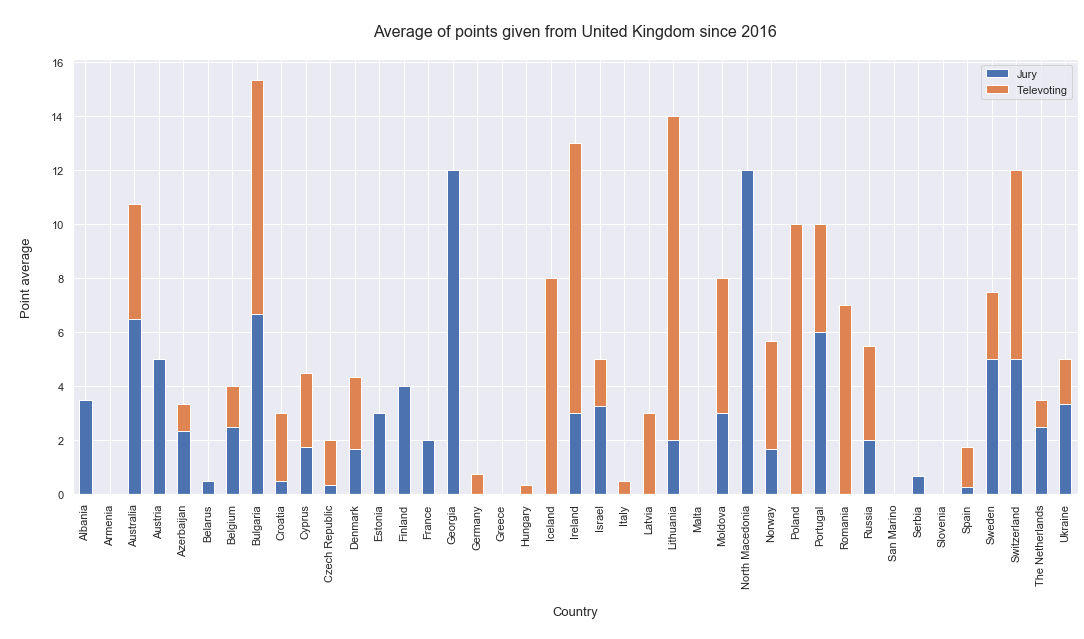

In [35]:
jvt("United Kingdom")

Countries which got significantly more points from the public:
<br>
Bulgaria, Croatia, Cyprus, Czech Republic, Denmark, Iceland, Ireland, Latvia, Lithuania, Moldova, Poland, Norway, Romania, Russia, Spain, Switzerland.
<br>
Countries with a large emigrant population to the United Kingdom:
<br>
Poland, Ireland, Germany, Italy, Lithuania, Portudal, Spain, Romania, Cyprus, Slovakia, Latvia, Bulgaria. 

As we can see, in all the countries we examined there's a clear connection and overlap between getting more points by televoting and having a large diaspora in that country. 

## Conclusion

The voting politics of Eurovision are complicated. There are strong faithful alliances, but this doesn't mean that the winner is predictable.  
<br>
Alliances change and outliers pop out, for example North Macedonia which got a lot of points in 2019, but hadn't qualified in the previous three finals, thus giving the impression that it consistently gets a lot of votes.
<br>
